In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [4]:
# Create directory if not existL
try:
    data_mask.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print("Image Mask folder is already there")
else:
    print("Image Mask folder was created")

info_csv = data_meta / "all_info.csv"

Image Mask folder is already there


In [5]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils as utils

# Read image and convert to rgb for segmentation

In [6]:
# Read dataframe containing images information
df = pd.read_csv(info_csv)

In [7]:
imgs, conditions = utils.get_composite_image(df)

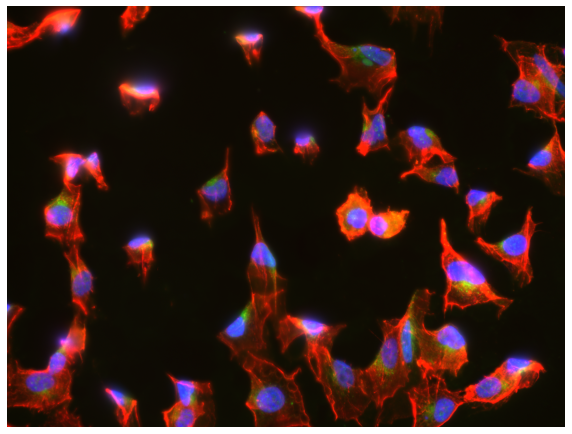

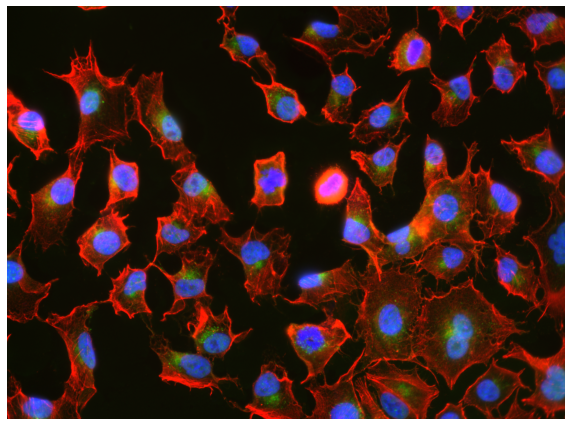

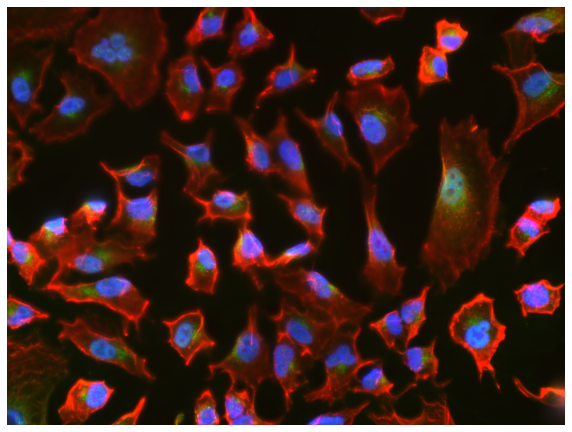

In [8]:
for img in imgs:
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)

# Segmentation with cellpose

In [9]:
def save_mask(masks, conditions, folder, cyto=True):
    for idx in range(len(masks)):
        if cyto:
            filename = "_".join([conditions[idx], "cyto_masks"])
        else:
            filename = "_".join([conditions[idx], "nuclei_masks"])
        path = os.path.join(folder, filename + ".tiff")
        cv2.imwrite(path, masks[idx])

** TORCH CUDA version installed and working. **
>>> GPU activated? 1
** TORCH CUDA version installed and working. **
>>>> using GPU
processing 3 image(s)


  0%|                                                                                                                                        | 0/3 [00:00<?, ?it/s]C:\Users\thu71\.conda\envs\work\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]


time spent: running network 5.10s; flow+mask computation 1.34
estimated masks for 3 image(s) in 7.35 sec
>>>> TOTAL TIME 7.36 sec


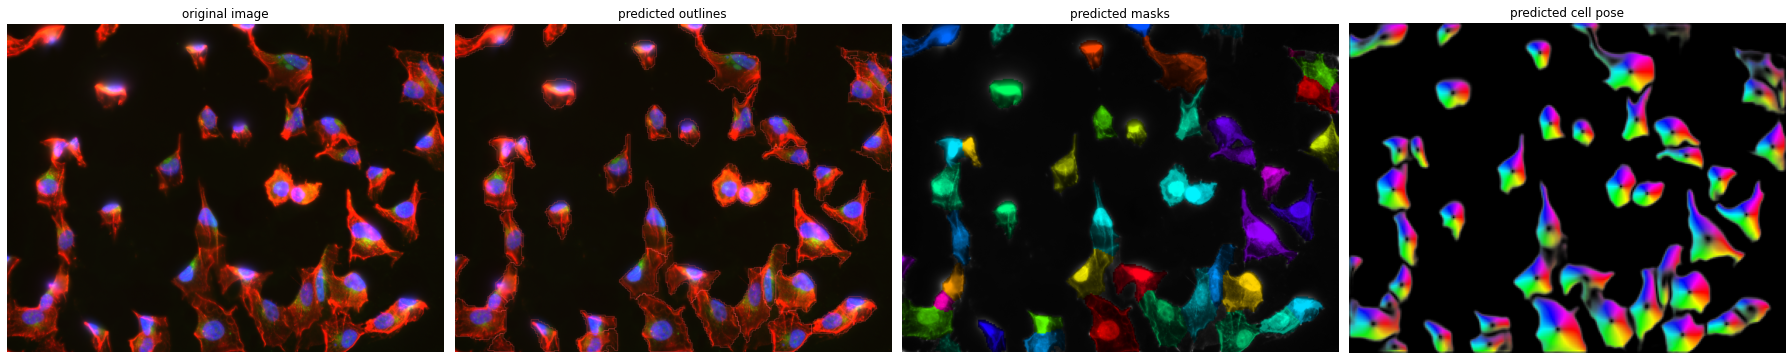

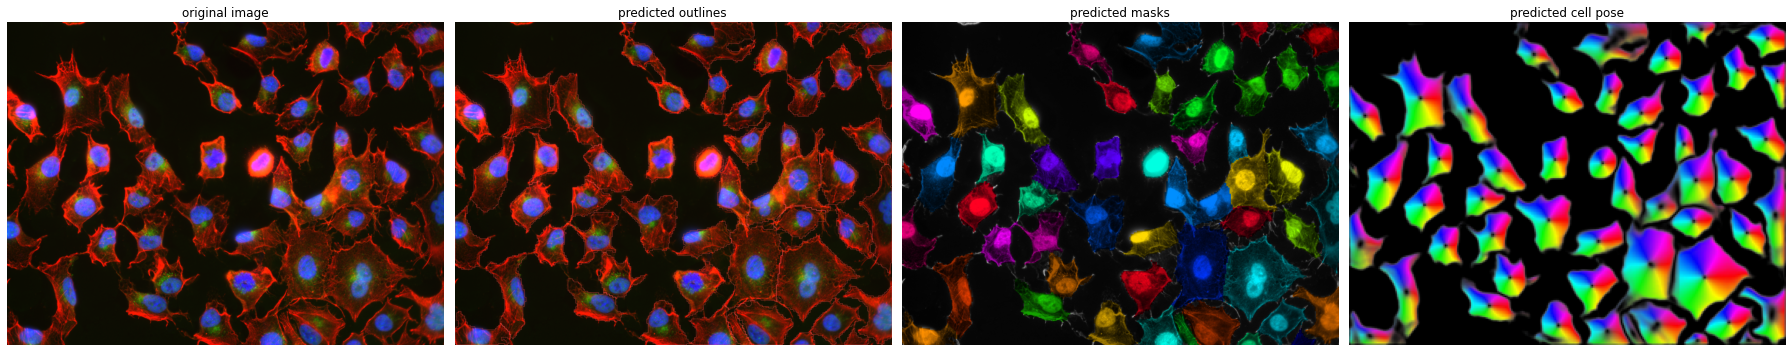

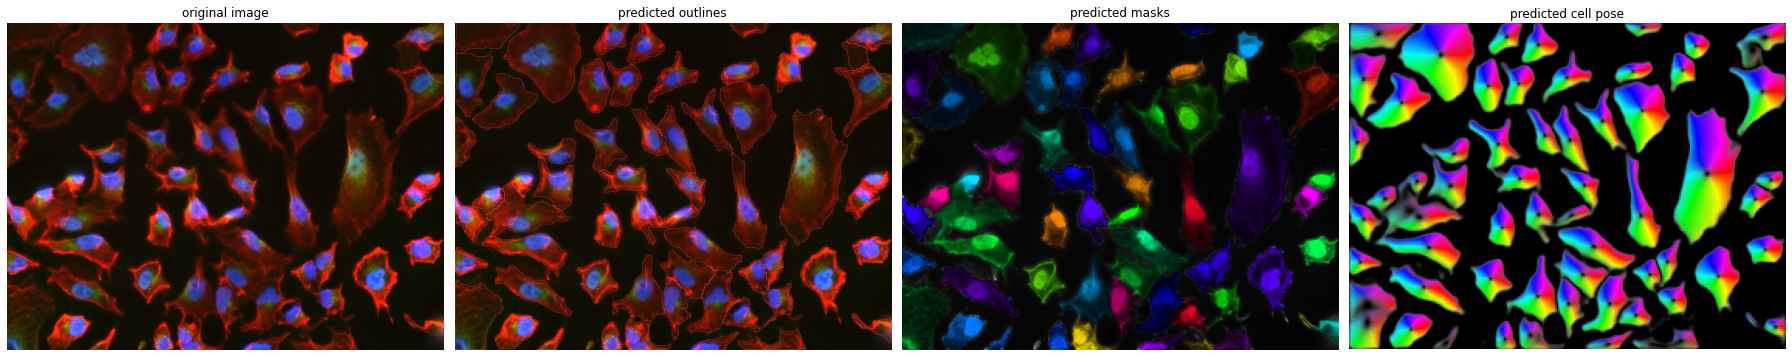

In [10]:
from cellpose import models, plot, utils

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)


# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type="cyto")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [1, 3]

masks, flows, styles, diams = model.eval(
    imgs, diameter=200, flow_threshold=None, channels=channels
)

nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(25, 15))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    plt.savefig(str(idx)+'.png', bbox_inches='tight')
    plt.show()

In [11]:
save_mask(masks, list(map(str, conditions)), data_mask)

## Nuclei channel segmentation

In [12]:
imgs_nuclei = [img[:, :, 2] for img in imgs]

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 3 image(s)


  0%|                                                                                                                                        | 0/3 [00:00<?, ?it/s]C:\Users\thu71\.conda\envs\work\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


time spent: running network 2.17s; flow+mask computation 1.49
estimated masks for 3 image(s) in 4.45 sec
>>>> TOTAL TIME 4.45 sec


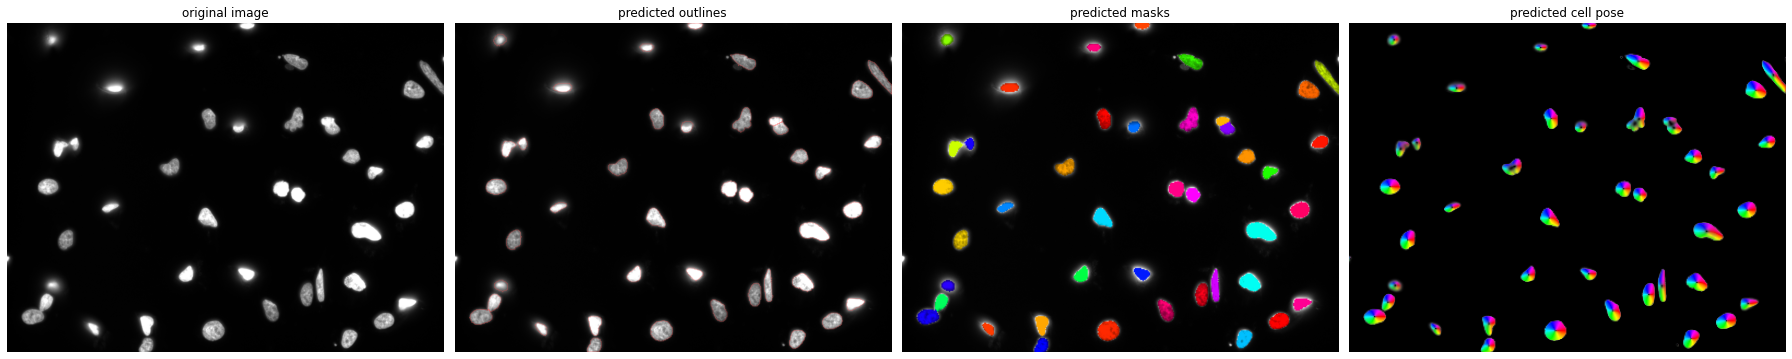

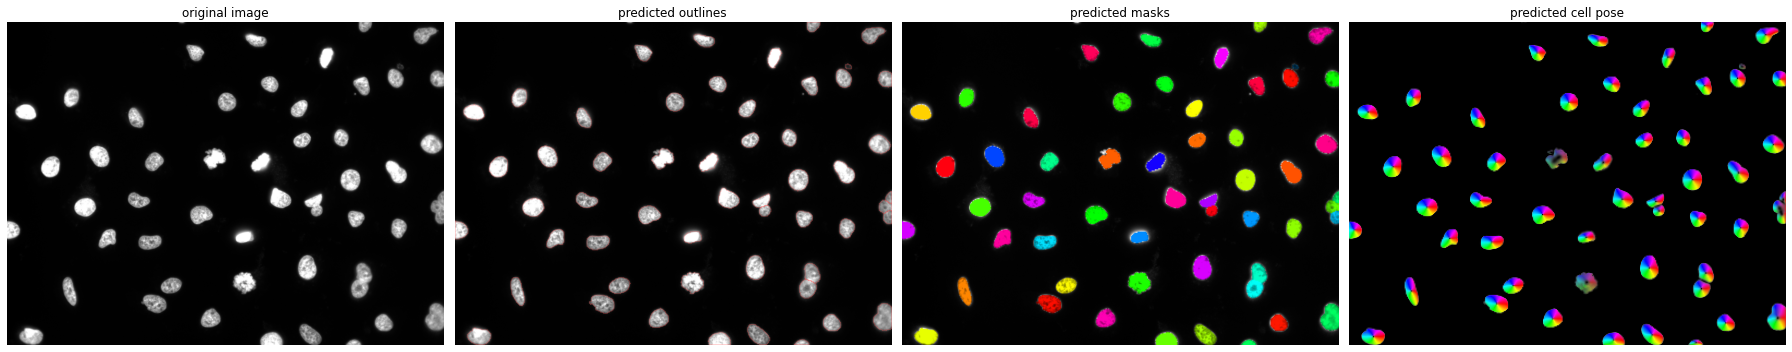

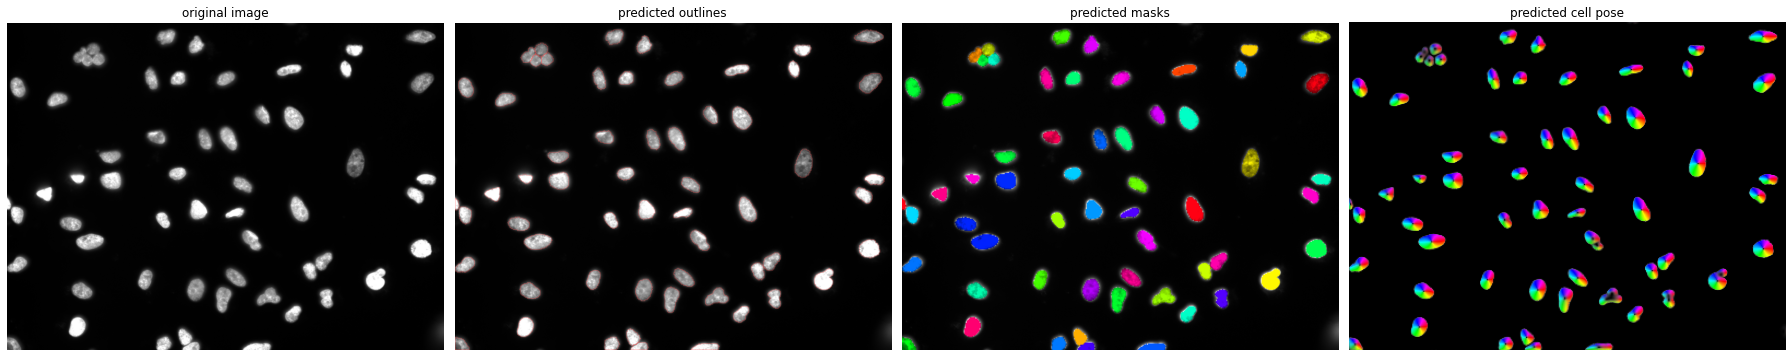

In [15]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type="nuclei")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [0, 0]

masks, flows, styles, diams = model.eval(
    imgs_nuclei, diameter=80, flow_threshold=None, channels=channels
)

nimg = len(imgs_nuclei)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(25, 15))
    plot.show_segmentation(fig, imgs_nuclei[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    #     plt.savefig(str(idx)+'.png')
    plt.show()

In [16]:
save_mask(masks, list(map(str, conditions)), data_mask, cyto=False)